# Human Pose Classification with MoveNet

## Preparation

In [172]:
import csv
import cv2
import itertools
import numpy as np
import pandas as pd
import os
import sys
import tempfile
import tqdm

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

### Code to run pose estimation using MoveNet

In [173]:
pose_sample_rpi_path = os.path.join(os.getcwd(), 'examples/lite/examples/pose_estimation/raspberry_pi')
sys.path.append(pose_sample_rpi_path)

# Load MoveNet Thunder model
import utils
from data import BodyPart
from ml import Movenet
movenet = Movenet('movenet_thunder')


# Define function to run pose estimation using MoveNet Thunder.
# You'll apply MoveNet's cropping algorithm and run inference multiple times on
# the input image to improve pose estimation accuracy.
def detect(input_tensor, inference_count=3):

  image_height, image_width, channel = input_tensor.shape
 
  # Detect pose using the full input image
  movenet.detect(input_tensor.numpy(), reset_crop_region=True)
 
  # Repeatedly using previous detection result to identify the region of
  # interest and only croping that region to improve detection accuracy
  for _ in range(inference_count - 1):
    person = movenet.detect(input_tensor.numpy(), 
                            reset_crop_region=False)

  return person

In [174]:
#Functions to visualize the pose estimation results.

def draw_prediction_on_image(
    image, person, crop_region=None, close_figure=True,
    keep_input_size=False):

  # Draw the detection result on top of the image.
  image_np = utils.visualize(image, [person])
  
  # Plot the image with detection results.
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  im = ax.imshow(image_np)
 
  if close_figure:
    plt.close(fig)
 
  if not keep_input_size:
    image_np = utils.keep_aspect_ratio_resizer(image_np, (512, 512))

  return image_np

In [175]:
#Code to load the images, detect pose landmarks and save them into a CSV file

class MoveNetPreprocessor(object):
  """Helper class to preprocess pose sample images for classification."""
 
  def __init__(self,
               images_in_folder,
               images_out_folder,
               csvs_out_path):

    self._images_in_folder = images_in_folder
    self._images_out_folder = images_out_folder
    self._csvs_out_path = csvs_out_path
    self._messages = []

    # Create a temp dir to store the pose CSVs per class
    self._csvs_out_folder_per_class = tempfile.mkdtemp()
 
    # Get list of pose classes and print image statistics
    self._pose_class_names = sorted(
        [n for n in os.listdir(self._images_in_folder) if not n.startswith('.')]
        )
    
  def process(self, per_pose_class_limit=None, detection_threshold=0.1):

    # Loop through the classes and preprocess its images
    for pose_class_name in self._pose_class_names:
      print('Preprocessing', pose_class_name, file=sys.stderr)

      # Paths for the pose class.
      images_in_folder = os.path.join(self._images_in_folder, pose_class_name)
      images_out_folder = os.path.join(self._images_out_folder, pose_class_name)
      csv_out_path = os.path.join(self._csvs_out_folder_per_class,
                                  pose_class_name + '.csv')
      if not os.path.exists(images_out_folder):
        os.makedirs(images_out_folder)
 
      # Detect landmarks in each image and write it to a CSV file
      with open(csv_out_path, 'w') as csv_out_file:
        csv_out_writer = csv.writer(csv_out_file, 
                                    delimiter=',', 
                                    quoting=csv.QUOTE_MINIMAL)
        # Get list of images
        image_names = sorted(
            [n for n in os.listdir(images_in_folder) if not n.startswith('.')])
        if per_pose_class_limit is not None:
          image_names = image_names[:per_pose_class_limit]

        valid_image_count = 0
 
        # Detect pose landmarks from each image
        for image_name in tqdm.tqdm(image_names):
          image_path = os.path.join(images_in_folder, image_name)

          try:
            image = tf.io.read_file(image_path)
            image = tf.io.decode_jpeg(image)
          except:
            self._messages.append('Skipped ' + image_path + '. Invalid image.')
            continue
          else:
            image = tf.io.read_file(image_path)
            image = tf.io.decode_jpeg(image)
            image_height, image_width, channel = image.shape
          
          # Skip images that isn't RGB because Movenet requires RGB images
          if channel != 3:
            self._messages.append('Skipped ' + image_path +
                                  '. Image isn\'t in RGB format.')
            continue
          person = detect(image)
          
          # Save landmarks if all landmarks were detected
          min_landmark_score = min(
              [keypoint.score for keypoint in person.keypoints])
          should_keep_image = min_landmark_score >= detection_threshold
          if not should_keep_image:
            self._messages.append('Skipped ' + image_path +
                                  '. No pose was confidentlly detected.')
            continue

          valid_image_count += 1

          # Draw the prediction result on top of the image for debugging later
          output_overlay = draw_prediction_on_image(
              image.numpy().astype(np.uint8), person, 
              close_figure=True, keep_input_size=True)
        
          # Write detection result into an image file
          output_frame = cv2.cvtColor(output_overlay, cv2.COLOR_RGB2BGR)
          cv2.imwrite(os.path.join(images_out_folder, image_name), output_frame)
        
          # Get landmarks and scale it to the same size as the input image
          pose_landmarks = np.array(
              [[keypoint.coordinate.x, keypoint.coordinate.y, keypoint.score]
                for keypoint in person.keypoints],
              dtype=np.float32)

          # Write the landmark coordinates to its per-class CSV file
          coordinates = pose_landmarks.flatten().astype(np.str).tolist()
          csv_out_writer.writerow([image_name] + coordinates)

        if not valid_image_count:
          raise RuntimeError(
              'No valid images found for the "{}" class.'
              .format(pose_class_name))
      
    # Print the error message collected during preprocessing.
    print('\n'.join(self._messages))

    # Combine all per-class CSVs into a single output file
    all_landmarks_df = self._all_landmarks_as_dataframe()
    all_landmarks_df.to_csv(self._csvs_out_path, index=False)

  def class_names(self):
    """List of classes found in the training dataset."""
    return self._pose_class_names
  
  def _all_landmarks_as_dataframe(self):
    """Merge all per-class CSVs into a single dataframe."""
    total_df = None
    for class_index, class_name in enumerate(self._pose_class_names):
      csv_out_path = os.path.join(self._csvs_out_folder_per_class,
                                  class_name + '.csv')
      per_class_df = pd.read_csv(csv_out_path, header=None)
      
      # Add the labels
      per_class_df['class_no'] = [class_index]*len(per_class_df)
      per_class_df['class_name'] = [class_name]*len(per_class_df)

      # Append the folder name to the filename column (first column)
      per_class_df[per_class_df.columns[0]] = (os.path.join(class_name, '') 
        + per_class_df[per_class_df.columns[0]].astype(str))

      if total_df is None:
        # For the first class, assign its data to the total dataframe
        total_df = per_class_df
      else:
        # Concatenate each class's data into the total dataframe
        total_df = pd.concat([total_df, per_class_df], axis=0)
 
    list_name = [[bodypart.name + '_x', bodypart.name + '_y', 
                  bodypart.name + '_score'] for bodypart in BodyPart] 
    header_name = []
    for columns_name in list_name:
      header_name += columns_name
    header_name = ['file_name'] + header_name
    header_map = {total_df.columns[i]: header_name[i] 
                  for i in range(len(header_name))}
 
    total_df.rename(header_map, axis=1, inplace=True)

    return total_df

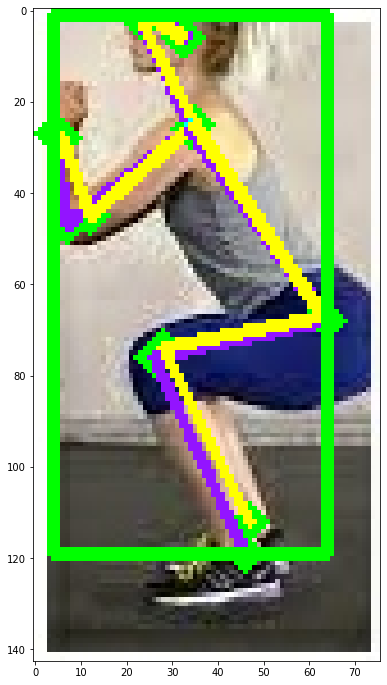

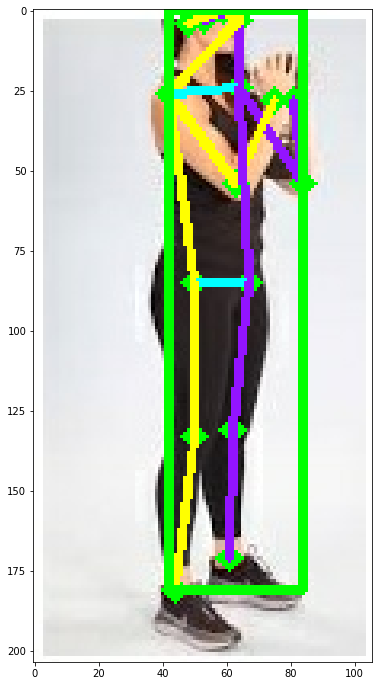

In [179]:
#Code snippet to try out the Movenet pose estimation logic

if len('./data/testimage(1).jpg'):
  image = tf.io.read_file('./data/testimage(1).jpg')
  image = tf.io.decode_jpeg(image)
  person = detect(image)
  _ = draw_prediction_on_image(image.numpy(), person, crop_region=None, 
                               close_figure=False, keep_input_size=True)
if len('./data/testimage(2).jpg'):
  image = tf.io.read_file('./data/testimage(2).jpg')
  image = tf.io.decode_jpeg(image)
  person = detect(image)
  _ = draw_prediction_on_image(image.numpy(), person, crop_region=None, 
                               close_figure=False, keep_input_size=True)

## Part 1: Preprocess the input images

In [180]:
is_skip_step_1 = False

In [181]:
use_custom_dataset = True

dataset_is_split = True

### Download the yoga dataset

In [182]:
IMAGES_ROOT = "squat_poses"

### Preprocess the `TRAIN` dataset

In [183]:
if not is_skip_step_1:
  images_in_train_folder = os.path.join(IMAGES_ROOT, 'train')
  images_out_train_folder = 'poses_images_out_train'
  csvs_out_train_path = 'train_data.csv'

  preprocessor = MoveNetPreprocessor(
      images_in_folder=images_in_train_folder,
      images_out_folder=images_out_train_folder,
      csvs_out_path=csvs_out_train_path,
  )

  preprocessor.process(per_pose_class_limit=None)

Preprocessing down
  0%|                                                    | 0/77 [00:00<?, ?it/s]/var/folders/62/7f2mld7d4tzbtwwc3j2y4xk40000gp/T/ipykernel_26963/2521659298.py:100: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  coordinates = pose_landmarks.flatten().astype(np.str).tolist()
100%|███████████████████████████████████████████| 77/77 [00:18<00:00,  4.09it/s]
Preprocessing up
100%|███████████████████████████████████████████| 96/96 [00:23<00:00,  4.02it/s]

Skipped squat_poses/train/down/KakaoTalk_Photo_2022-06-11-21-29-44 001.jpeg. No pose was confidentlly detected.
Skipped squat_poses/train/down/KakaoTalk_Photo_2022-06-11-21-29-44 004.jpeg. No pose was confidentlly detected.
Skipped squat_poses/train/down/KakaoTalk_Photo_2022-06-11-21-29-44 009.jpeg. No pose was confidentlly detected.
Skipped squat_poses/train/down/KakaoTalk_Photo_2022-06-11-21-29-44 015.jpeg. No pose was confidentlly detected.
Skipped squat_poses/train/down/KakaoTalk_Photo_2022-06-11-21-29-44 016.jpeg. No pose was confidentlly detected.
Skipped squat_poses/train/down/KakaoTalk_Photo_2022-06-11-21-29-44 020.jpeg. No pose was confidentlly detected.
Skipped squat_poses/train/down/KakaoTalk_Photo_2022-06-11-21-29-44 021.jpeg. No pose was confidentlly detected.
Skipped squat_poses/train/down/KakaoTalk_Photo_2022-06-11-21-29-44 023.jpeg. No pose was confidentlly detected.
Skipped squat_poses/train/down/KakaoTalk_Photo_2022-06-11-21-30-04 006.jpeg. No pose was confidentlly de

### Preprocess the `TEST` dataset

In [184]:
if not is_skip_step_1:
  images_in_test_folder = os.path.join(IMAGES_ROOT, 'test')
  images_out_test_folder = 'poses_images_out_test'
  csvs_out_test_path = 'test_data.csv'

  preprocessor = MoveNetPreprocessor(
      images_in_folder=images_in_test_folder,
      images_out_folder=images_out_test_folder,
      csvs_out_path=csvs_out_test_path,
  )

  preprocessor.process(per_pose_class_limit=None)

Preprocessing down
  0%|                                                    | 0/67 [00:00<?, ?it/s]/var/folders/62/7f2mld7d4tzbtwwc3j2y4xk40000gp/T/ipykernel_26963/2521659298.py:100: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  coordinates = pose_landmarks.flatten().astype(np.str).tolist()
100%|███████████████████████████████████████████| 67/67 [00:12<00:00,  5.32it/s]
Preprocessing up
 56%|██████████████████████▊                  | 242/435 [00:40<00:31,  6.21it/s]/Users/sunhee/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/sunhee/opt/anaconda3/lib/python3.9/site-packages/numpy/c

Skipped squat_poses/test/down/img118_cropped_.jpg. No pose was confidentlly detected.
Skipped squat_poses/test/down/img19_cropped_.jpg. No pose was confidentlly detected.
Skipped squat_poses/test/down/img21_cropped_.jpg. No pose was confidentlly detected.
Skipped squat_poses/test/down/img2_304_cropped_.jpg. No pose was confidentlly detected.
Skipped squat_poses/test/down/img45_cropped_.jpg. No pose was confidentlly detected.
Skipped squat_poses/test/down/img4_204_cropped_.jpg. No pose was confidentlly detected.
Skipped squat_poses/test/down/img6_cropped_.jpg. No pose was confidentlly detected.
Skipped squat_poses/test/down/img93_cropped_.jpg. No pose was confidentlly detected.
Skipped squat_poses/test/up/img106_cropped_.jpg. No pose was confidentlly detected.
Skipped squat_poses/test/up/img117_cropped_.jpg. No pose was confidentlly detected.
Skipped squat_poses/test/up/img118_cropped_.jpg. No pose was confidentlly detected.
Skipped squat_poses/test/up/img122_cropped_.jpg. No pose was c

## Train a pose classification model that takes the landmark coordinates as input, and output the predicted labels.


In [185]:
csvs_out_train_path = 'train_data.csv'
csvs_out_test_path = 'test_data.csv'
is_skipped_step_1 = True

### Load the preprocessed CSVs into `TRAIN` and `TEST` datasets.

In [186]:
def load_pose_landmarks(csv_path):

  # Load the CSV file
  dataframe = pd.read_csv(csv_path)
  df_to_process = dataframe.copy()

  # Drop the file_name columns as you don't need it during training.
  df_to_process.drop(columns=['file_name'], inplace=True)

  # Extract the list of class names
  classes = df_to_process.pop('class_name').unique()

  # Extract the labels
  y = df_to_process.pop('class_no')

  # Convert the input features and labels into the correct format for training.
  X = df_to_process.astype('float64')
  y = keras.utils.to_categorical(y)

  return X, y, classes, dataframe

In [189]:
# Load the train data
X, y, class_names, dataframe = load_pose_landmarks(csvs_out_train_path)

# Split training data (X, y) into (X_train, y_train) and (X_val, y_val)
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.15)

In [190]:
# Load the test data
X_test, y_test, _, df_test = load_pose_landmarks(csvs_out_test_path)

### Define functions to convert the pose landmarks to a pose embedding (a.k.a. feature vector) for pose classification

In [191]:
def get_center_point(landmarks, left_bodypart, right_bodypart):
  """Calculates the center point of the two given landmarks."""

  left = tf.gather(landmarks, left_bodypart.value, axis=1)
  right = tf.gather(landmarks, right_bodypart.value, axis=1)
  center = left * 0.5 + right * 0.5
  return center


def get_pose_size(landmarks, torso_size_multiplier=2.5):
  """Calculates pose size.
  """
  # Hips center
  hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)

  # Shoulders center
  shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER,
                                      BodyPart.RIGHT_SHOULDER)

  # Torso size as the minimum body size
  torso_size = tf.linalg.norm(shoulders_center - hips_center)

  # Pose center
  pose_center_new = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                     BodyPart.RIGHT_HIP)
  pose_center_new = tf.expand_dims(pose_center_new, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to
  # perform substraction
  pose_center_new = tf.broadcast_to(pose_center_new,
                                    [tf.size(landmarks) // (17*2), 17, 2])

  # Dist to pose center
  d = tf.gather(landmarks - pose_center_new, 0, axis=0,
                name="dist_to_pose_center")
  # Max dist to pose center
  max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

  # Normalize scale
  pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)

  return pose_size


def normalize_pose_landmarks(landmarks):
  # Move landmarks so that the pose center becomes (0,0)
  pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)
  pose_center = tf.expand_dims(pose_center, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to perform
  # substraction
  pose_center = tf.broadcast_to(pose_center, 
                                [tf.size(landmarks) // (17*2), 17, 2])
  landmarks = landmarks - pose_center

  # Scale the landmarks to a constant pose size
  pose_size = get_pose_size(landmarks)
  landmarks /= pose_size

  return landmarks


def landmarks_to_embedding(landmarks_and_scores):
  """Converts the input landmarks into a pose embedding."""
  # Reshape the flat input into a matrix with shape=(17, 3)
  reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

  # Normalize landmarks 2D
  landmarks = normalize_pose_landmarks(reshaped_inputs[:, :, :2])

  # Flatten the normalized landmark coordinates into a vector
  embedding = keras.layers.Flatten()(landmarks)

  return embedding

### Define a Keras model for pose classification

In [192]:
# Define the model
inputs = tf.keras.Input(shape=(51))
embedding = landmarks_to_embedding(inputs)

layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 51)]         0           []                               
                                                                                                  
 reshape_8 (Reshape)            (None, 17, 3)        0           ['input_9[0][0]']                
                                                                                                  
 tf.__operators__.getitem_8 (Sl  (None, 17, 2)       0           ['reshape_8[0][0]']              
 icingOpLambda)                                                                                   
                                                                                                  
 tf.compat.v1.gather_72 (TFOpLa  (None, 2)           0           ['tf.__operators__.getitem_

 a)                                                                                               
                                                                                                  
 tf.math.multiply_75 (TFOpLambd  (None, 2)           0           ['tf.compat.v1.gather_75[0][0]'] 
 a)                                                                                               
                                                                                                  
 tf.broadcast_to_17 (TFOpLambda  (None, 17, 2)       0           ['tf.expand_dims_17[0][0]',      
 )                                                                'tf.compat.v1.floor_div_17[0][0]
                                                                 ']                               
                                                                                                  
 tf.__operators__.add_34 (TFOpL  (None, 2)           0           ['tf.math.multiply_76[0][0]',    
 ambda)   

In [193]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
checkpoint_path = "weights.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                              patience=20)

# Start training
history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
1/8 [==>...........................] - ETA: 3s - loss: 0.7250 - accuracy: 0.3125
Epoch 1: val_accuracy improved from -inf to 0.95652, saving model to weights.best.hdf5
8/8 [==============================] - 1s 43ms/step - loss: 0.6941 - accuracy: 0.5280 - val_loss: 0.6719 - val_accuracy: 0.9565
Epoch 2/200
1/8 [==>...........................] - ETA: 0s - loss: 0.6834 - accuracy: 0.7500
Epoch 2: val_accuracy did not improve from 0.95652
8/8 [==============================] - 0s 6ms/step - loss: 0.6610 - accuracy: 0.8320 - val_loss: 0.6390 - val_accuracy: 0.9565
Epoch 3/200
1/8 [==>...........................] - ETA: 0s - loss: 0.6505 - accuracy: 0.8125
Epoch 3: val_accuracy improved from 0.95652 to 1.00000, saving model to weights.best.hdf5
8/8 [==============================] - 0s 14ms/step - loss: 0.6369 - accuracy: 0.8400 - val_loss: 0.5972 - val_accuracy: 1.0000
Epoch 4/200
1/8 [==>...........................] - ETA: 0s - loss: 0.6170 - accuracy: 0.7500
Epoch 4: val_accu

In [194]:
history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0092 - accuracy: 1.0000
Epoch 1: val_accuracy did not improve from 1.00000
8/8 [==============================] - 0s 14ms/step - loss: 0.0117 - accuracy: 1.0000 - val_loss: 0.0672 - val_accuracy: 0.9565
Epoch 2/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0163 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 1.00000
8/8 [==============================] - 0s 6ms/step - loss: 0.0172 - accuracy: 1.0000 - val_loss: 0.0705 - val_accuracy: 0.9565
Epoch 3/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0222 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
8/8 [==============================] - 0s 7ms/step - loss: 0.0119 - accuracy: 1.0000 - val_loss: 0.0713 - val_accuracy: 0.9565
Epoch 4/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0058 - accuracy: 1.0000
Epoch 4: val_accuracy did not improve from 1.00000
8/8 [==============================] - 0s 

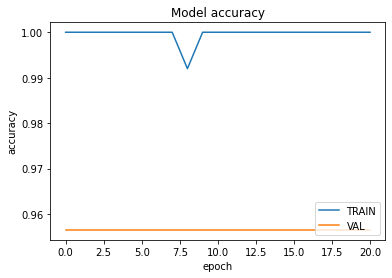

In [195]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

In [196]:
# Evaluate the model using the TEST dataset
loss, accuracy = model.evaluate(X_test, y_test)

9/9 [==============================] - 0s 2ms/step - loss: 1.3377 - accuracy: 0.7829


### Draw the confusion matrix to better understand the model performance

9/9 [==============================] - 0s 1ms/step
Confusion matrix, without normalization

Classification Report:
               precision    recall  f1-score   support

        down       0.53      0.47      0.50        59
          up       0.85      0.87      0.86       199

    accuracy                           0.78       258
   macro avg       0.69      0.67      0.68       258
weighted avg       0.78      0.78      0.78       258



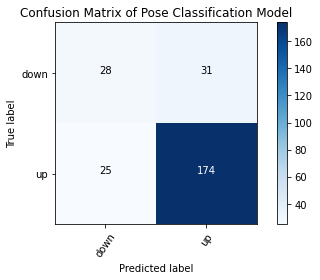

In [198]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """Plots the confusion matrix."""
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=55)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()

# Classify pose in the TEST dataset using the trained model
y_pred = model.predict(X_test)

# Convert the prediction result to class name
y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

# Plot the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      class_names,
                      title ='Confusion Matrix of Pose Classification Model')

# Print the classification report
print('\nClassification Report:\n', classification_report(y_true_label,
                                                          y_pred_label))

### Investigate incorrect predictions


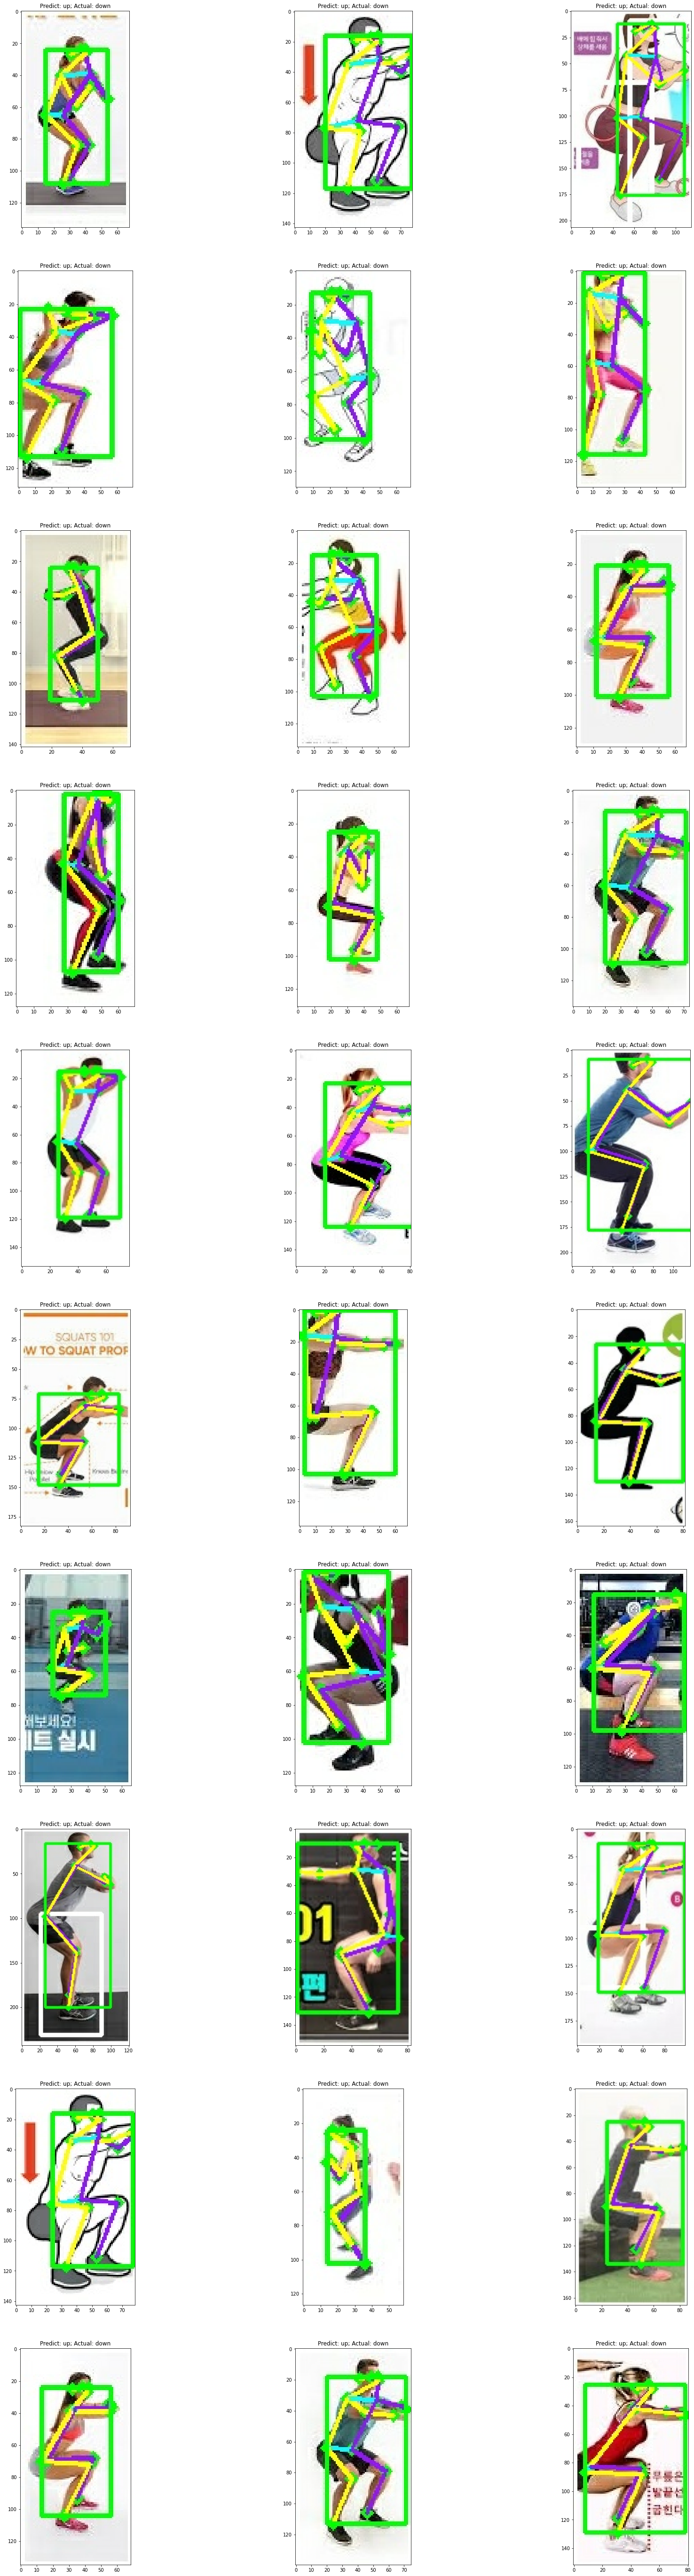

In [199]:
if is_skip_step_1:
  raise RuntimeError('You must have run step 1 to run this cell.')

# If step 1 was skipped, skip this step.
IMAGE_PER_ROW = 3
MAX_NO_OF_IMAGE_TO_PLOT = 30

# Extract the list of incorrectly predicted poses
false_predict = [id_in_df for id_in_df in range(len(y_test)) \
                if y_pred_label[id_in_df] != y_true_label[id_in_df]]
if len(false_predict) > MAX_NO_OF_IMAGE_TO_PLOT:
  false_predict = false_predict[:MAX_NO_OF_IMAGE_TO_PLOT]

# Plot the incorrectly predicted images
row_count = len(false_predict) // IMAGE_PER_ROW + 1
fig = plt.figure(figsize=(10 * IMAGE_PER_ROW, 10 * row_count))
for i, id_in_df in enumerate(false_predict):
  ax = fig.add_subplot(row_count, IMAGE_PER_ROW, i + 1)
  image_path = os.path.join(images_out_test_folder,
                            df_test.iloc[id_in_df]['file_name'])

  image = cv2.imread(image_path)
  plt.title("Predict: %s; Actual: %s"
            % (y_pred_label[id_in_df], y_true_label[id_in_df]))
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In [200]:
def evaluate_model(interpreter, X, y_true):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on all given poses.
  y_pred = []
  for i in range(len(y_true)):
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = X[i: i + 1].astype('float32')
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the class with highest
    # probability.
    output = interpreter.tensor(output_index)
    predicted_label = np.argmax(output()[0])
    y_pred.append(predicted_label)

  # Compare prediction results with ground truth labels to calculate accuracy.
  y_pred = keras.utils.to_categorical(y_pred)
  return accuracy_score(y_true, y_pred)

# Evaluate the accuracy of the converted TFLite model
classifier_interpreter = tf.lite.Interpreter(model_content=tflite_model)
classifier_interpreter.allocate_tensors()
print('Accuracy of TFLite model: %s' %
      evaluate_model(classifier_interpreter, X_test, y_test))

Accuracy of TFLite model: 0.7635658914728682


In [201]:
test_result=model.predict(X_test)

9/9 [==============================] - 0s 2ms/step


In [202]:
label=[]
for i in test_result:
    if i[0] > i[1]:
        label.append(0)
    else :
        label.append(1)

In [203]:
df_test['label']=label

In [204]:
df_test

,file_name,NOSE_x,NOSE_y,NOSE_score,LEFT_EYE_x,LEFT_EYE_y,LEFT_EYE_score,RIGHT_EYE_x,RIGHT_EYE_y,RIGHT_EYE_score,...,RIGHT_KNEE_score,LEFT_ANKLE_x,LEFT_ANKLE_y,LEFT_ANKLE_score,RIGHT_ANKLE_x,RIGHT_ANKLE_y,RIGHT_ANKLE_score,class_no,class_name,label
0,down/img103_cropped_.jpg,40.0,26.0,0.786021,40.0,24.0,0.849988,37.0,24.0,0.896158,...,0.595113,30.0,106.0,0.842434,26.0,108.0,0.786135,0,down,1
1,down/img119_cropped_.jpg,54.0,20.0,0.723611,55.0,16.0,0.847335,50.0,17.0,0.847828,...,0.602117,54.0,112.0,0.666000,35.0,117.0,0.546439,0,down,1
2,down/img124_cropped_.jpg,27.0,2.0,0.298317,26.0,1.0,0.229389,33.0,1.0,0.313798,...,0.193324,52.0,144.0,0.541967,83.0,136.0,0.647754,0,down,0
3,down/img125_cropped_.jpg,80.0,16.0,0.671970,77.0,12.0,0.667322,74.0,13.0,0.709914,...,0.620751,84.0,161.0,0.797703,47.0,176.0,0.784893,0,down,1
4,down/img133_cropped_.jpg,44.0,29.0,0.707354,44.0,26.0,0.769751,42.0,26.0,0.813595,...,0.842374,26.0,109.0,0.899701,5.0,113.0,0.875304,0,down,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,up/img82_cropped_.jpg,33.0,72.0,0.734797,33.0,70.0,0.688769,32.0,71.0,0.869152,...,0.635883,29.0,113.0,0.743406,21.0,115.0,0.944382,1,up,1
254,up/img86_cropped_.jpg,1.0,4.0,0.251921,3.0,1.0,0.275642,1.0,2.0,0.258064,...,0.725286,38.0,118.0,0.691539,38.0,109.0,0.721015,1,up,0
255,up/img96_cropped_.jpg,42.0,29.0,0.602314,43.0,26.0,0.660458,39.0,26.0,0.503315,...,0.725466,45.0,155.0,0.191174,28.0,152.0,0.221315,1,up,1
256,up/img97_cropped_.jpg,58.0,24.0,0.256082,63.0,20.0,0.367428,57.0,20.0,0.309997,...,0.393816,68.0,92.0,0.350513,32.0,107.0,0.781902,1,up,1


In [205]:
len(df_test.loc[df_test['label']==0])  ##down data 개수 확인

53

In [206]:
df_test_down = df_test.loc[df_test['label']==0]
df_test_name = list(df_test_down['file_name']) ##라벨이 0인 데이터만 리스트로 저장

In [207]:
df_test_name

['down/img124_cropped_.jpg',
 'down/img156_cropped_.jpg',
 'down/img209_cropped_.jpg',
 'down/img20_cropped_.jpg',
 'down/img22_cropped_.jpg',
 'down/img275_cropped_.jpg',
 'down/img2_119_cropped_.jpg',
 'down/img2_161_cropped_.jpg',
 'down/img2_170_cropped_.jpg',
 'down/img2_273_cropped_.jpg',
 'down/img2_274_cropped_.jpg',
 'down/img2_2_cropped_.jpg',
 'down/img2_334_cropped_.jpg',
 'down/img2_395_cropped_.jpg',
 'down/img2_46_cropped_.jpg',
 'down/img2_47_cropped_.jpg',
 'down/img2_8_cropped_.jpg',
 'down/img2_93_cropped_.jpg',
 'down/img31_cropped_.jpg',
 'down/img3_12_cropped_.jpg',
 'down/img3_329_cropped_.jpg',
 'down/img46_cropped_.jpg',
 'down/img4_218_cropped_.jpg',
 'down/img4_21_cropped_.jpg',
 'down/img4_314_cropped_.jpg',
 'down/img4_5_cropped_.jpg',
 'down/img4_7_cropped_.jpg',
 'down/img74_cropped_.jpg',
 'up/img132_cropped_.jpg',
 'up/img186_cropped_.jpg',
 'up/img20_cropped_.jpg',
 'up/img22_cropped_.jpg',
 'up/img2_129_cropped_.jpg',
 'up/img2_133_cropped_.jpg',
 'up

In [208]:
for i in range(len(df_test_name)):
    df_test_name[i] = df_test_name[i].replace('down/', '')
    df_test_name[i] = df_test_name[i].replace('up/', '')

In [209]:
df_test_name

['img124_cropped_.jpg',
 'img156_cropped_.jpg',
 'img209_cropped_.jpg',
 'img20_cropped_.jpg',
 'img22_cropped_.jpg',
 'img275_cropped_.jpg',
 'img2_119_cropped_.jpg',
 'img2_161_cropped_.jpg',
 'img2_170_cropped_.jpg',
 'img2_273_cropped_.jpg',
 'img2_274_cropped_.jpg',
 'img2_2_cropped_.jpg',
 'img2_334_cropped_.jpg',
 'img2_395_cropped_.jpg',
 'img2_46_cropped_.jpg',
 'img2_47_cropped_.jpg',
 'img2_8_cropped_.jpg',
 'img2_93_cropped_.jpg',
 'img31_cropped_.jpg',
 'img3_12_cropped_.jpg',
 'img3_329_cropped_.jpg',
 'img46_cropped_.jpg',
 'img4_218_cropped_.jpg',
 'img4_21_cropped_.jpg',
 'img4_314_cropped_.jpg',
 'img4_5_cropped_.jpg',
 'img4_7_cropped_.jpg',
 'img74_cropped_.jpg',
 'img132_cropped_.jpg',
 'img186_cropped_.jpg',
 'img20_cropped_.jpg',
 'img22_cropped_.jpg',
 'img2_129_cropped_.jpg',
 'img2_133_cropped_.jpg',
 'img2_269_cropped_.jpg',
 'img2_285_cropped_.jpg',
 'img2_44_cropped_.jpg',
 'img2_63_cropped_.jpg',
 'img2_81_cropped_.jpg',
 'img31_cropped_.jpg',
 'img328_cro

In [211]:
import pickle

with open("imglist.pkl","wb") as f:
    pickle.dump(df_test_name, f) #이미지 리스트 pickle 파일로 저장